<h1>台積電擴大赴美投資情緒分析1</h1>
<h2>套件與設定</h2>


In [70]:
#套件載入
import pandas as pd
import os
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import opencc
#繪圖設定
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
# 設定文字雲中文字體路徑
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型

<h2>2.資料介紹與清理</h2>
<h3>2.1資料簡介</h3>
<ul>
<li>資料來源:PTT-stock版文章</li>
<li>爬取工具:tarflow工具</li>
<li>關鍵字:台積電,美積電,亞利桑那</li>
<li>取用期間:2024/10/01~2025/3/12</li>  
<li>文章筆數:2,546</li>
</ul>


<h3>2.2資料清理</h3>
<ul>
<li>刪除內文為空值的文章</li>
<li>PTT常以兩個換行符號作為結尾，因此將其取代為句號</li>
<li>清除不重要的字，如換行或網址</li>
</ul>

In [71]:
#read file
## 讀取文章
df = pd.read_csv('./raw_data/program1.csv')
# 確保 artDate 欄位為字串，避免雜訊
df["artDate"] = df["artDate"].astype(str).str.strip()
# 嘗試轉換日期，錯誤的值變成 NaT
df["artDate"] = pd.to_datetime(df["artDate"], errors="coerce")
# 檢查無效日期
#print("無效日期數量:", df["artDate"].isna().sum())
# 查看無效日期的前 20 筆
#invalid_dates = df[df["artDate"].isna()]
#print(invalid_dates[["artDate"]].head(20))
# 選擇是否要刪除無效日期
df = df.dropna(subset=["artDate"])
print("artDate 已成功轉換，合併後的 DataFrame：")
df["artDate"] = df["artDate"].dt.date
df.info()
df.head(10)

artDate 已成功轉換，合併後的 DataFrame：
<class 'pandas.core.frame.DataFrame'>
Index: 2547 entries, 0 to 2745
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   system_id     2547 non-null   object
 1   artUrl        2547 non-null   object
 2   artTitle      2547 non-null   object
 3   artDate       2547 non-null   object
 4   artPoster     2547 non-null   object
 5   artCatagory   2546 non-null   object
 6   artContent    2541 non-null   object
 7   artComment    2546 non-null   object
 8   e_ip          2279 non-null   object
 9   insertedDate  2365 non-null   object
 10  dataSource    2365 non-null   object
dtypes: object(11)
memory usage: 238.8+ KB


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,Lefty,Stock,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""kkes0001"", ""...",180.177.26.33,2024/9/2 2:03,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1725197370.A.1F...,[標的]大盤跟外資喊話多,2024-09-01,derrengay,Stock,帕拉迪島=台灣\n\n調查兵團=台積電\n\n艾倫=張忠謀\n\n我在這邊公開跟會看PTT的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""xxgogg"", ""cm...",112.78.86.207,2024/9/2 2:03,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1725198616.A.9A...,[新聞]黑悟空帶飛台灣PC、遊戲股？鈊象、大宇,2024-09-01,cjol,Stock,黑悟空帶飛台灣PC、遊戲股？鈊象、大宇資、宇峻齊紅！智崴漲近半根\n\n\nFTNN新聞網\...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""st9061204"", ...",122.117.2.178,2024/9/2 2:03,ptt
3,4,https://www.ptt.cc/bbs/Stock/M.1725240995.A.EA...,[新聞]悟空也難救？面板廠9月起擴大減產,2024-09-02,ann16,Stock,原文標題：悟空也難救？面板廠9月起擴大減產\n原文連結：\nhttps://reurl.cc...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""GoGoRoll"", ""...",203.145.94.152,2024/9/3 2:10,ptt
4,5,https://www.ptt.cc/bbs/Stock/M.1725256802.A.98...,[閒聊]2024/09/02盤後閒聊,2024-09-02,vendan5566,Stock,"台股\n成交量2861.94億\n台指09\n成交量 72,167口\n櫃買指\n成交量11...","[{""cmtStatus"": ""噓"", ""cmtPoster"": ""addy7533967""...",NaN,NaN,NaN
7,6,https://www.ptt.cc/bbs/Stock/M.1725264328.A.43...,[情報]0902上市外資買賣超排行,2024-09-02,paidzou,Stock,1. 標題：0902 上市外資買賣超排行\n\n2. 來源：TWSE\n\n3. 網址：\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""a210510"", ""c...",223.136.116.224,2024/9/3 2:10,ptt
8,7,https://www.ptt.cc/bbs/Stock/M.1725269627.A.BC...,[新聞]台積電亞利桑那三廠已動工！州政府官員親口,2024-09-02,DrowningPool,Stock,原文標題：台積電亞利桑那三廠已動工！州政府官員親口證實\n\n原文連結：\nhttps://...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""hong92"", ""cm...",218.32.44.219,2024/9/3 2:10,ptt
9,8,https://www.ptt.cc/bbs/Stock/M.1725271202.A.22...,[新聞]台積電埃米級製程訂單來了A16未量產先轟,2024-09-02,MOMO0478,Stock,原文標題：\n台積電埃米級製程訂單來了 A16未量產先轟動\n\n\n原文連結：\nhttp...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""cuteme5566"",...",59.120.193.115,2024/9/3 2:10,ptt
10,9,https://www.ptt.cc/bbs/Stock/M.1725281128.A.AB...,Re:[新聞]台積電亞利桑那三廠已動工！州政府官員親口,2024-09-02,ting970501,Stock,台積電不會讓人失望的\n繼續蓋廠 毛利就更低\n其實這些佈局根本不是經濟考量啦\n\n以現在...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""MOMO0478"", ""...",42.73.99.16,2024/9/3 2:10,ptt
11,10,https://www.ptt.cc/bbs/Stock/M.1725285098.A.A3...,[情報]113年09月02日信用交易統計,2024-09-02,steward135,Stock,1. 標題：113年09月02日信用交易統計\n2. 來源：臺灣證券交易所、證券櫃檯買賣中心...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""johnbill"", ""...",36.224.68.162,2024/9/3 2:10,ptt


In [72]:
clear_df = df.copy()
raw_df = df.copy()
#清除無用欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...","標的：，TW 台積電，分類：多，分析/正文：。今年第三季靠近尾端了, 打一些第四季或明年展望..."
1,https://www.ptt.cc/bbs/Stock/M.1725197370.A.1F...,[標的]大盤跟外資喊話多,2024-09-01,帕拉迪島=台灣\n\n調查兵團=台積電\n\n艾倫=張忠謀\n\n我在這邊公開跟會看PTT的...,帕拉迪島=台灣。調查兵團=台積電。艾倫=張忠謀。我在這邊公開跟會看PTT的外資講四個字。儘快...
2,https://www.ptt.cc/bbs/Stock/M.1725198616.A.9A...,[新聞]黑悟空帶飛台灣PC、遊戲股？鈊象、大宇,2024-09-01,黑悟空帶飛台灣PC、遊戲股？鈊象、大宇資、宇峻齊紅！智崴漲近半根\n\n\nFTNN新聞網\...,黑悟空帶飛台灣PC、遊戲股？鈊象、大宇資、宇峻齊紅！智崴漲近半根。，FTNN新聞網，2024...
3,https://www.ptt.cc/bbs/Stock/M.1725240995.A.EA...,[新聞]悟空也難救？面板廠9月起擴大減產,2024-09-02,原文標題：悟空也難救？面板廠9月起擴大減產\n原文連結：\nhttps://reurl.cc...,原文標題：悟空也難救？面板廠9月起擴大減產，原文連結：， 週一 上午4:10，記者署名：袁顥...
4,https://www.ptt.cc/bbs/Stock/M.1725256802.A.98...,[閒聊]2024/09/02盤後閒聊,2024-09-02,"台股\n成交量2861.94億\n台指09\n成交量 72,167口\n櫃買指\n成交量11...","台股，成交量2861.94億，台指09，成交量 72,167口，櫃買指，成交量1195.80..."
7,https://www.ptt.cc/bbs/Stock/M.1725264328.A.43...,[情報]0902上市外資買賣超排行,2024-09-02,1. 標題：0902 上市外資買賣超排行\n\n2. 來源：TWSE\n\n3. 網址：\n...,1. 標題：0902 上市外資買賣超排行。2. 來源：TWSE。3. 網址：， 內文：。買超...
8,https://www.ptt.cc/bbs/Stock/M.1725269627.A.BC...,[新聞]台積電亞利桑那三廠已動工！州政府官員親口,2024-09-02,原文標題：台積電亞利桑那三廠已動工！州政府官員親口證實\n\n原文連結：\nhttps://...,原文標題：台積電亞利桑那三廠已動工！州政府官員親口證實。原文連結：， Watson出席駐台貿...
9,https://www.ptt.cc/bbs/Stock/M.1725271202.A.22...,[新聞]台積電埃米級製程訂單來了A16未量產先轟,2024-09-02,原文標題：\n台積電埃米級製程訂單來了 A16未量產先轟動\n\n\n原文連結：\nhttp...,原文標題：，台積電埃米級製程訂單來了 A16未量產先轟動。，原文連結：， 03:28:58，...
10,https://www.ptt.cc/bbs/Stock/M.1725281128.A.AB...,Re:[新聞]台積電亞利桑那三廠已動工！州政府官員親口,2024-09-02,台積電不會讓人失望的\n繼續蓋廠 毛利就更低\n其實這些佈局根本不是經濟考量啦\n\n以現在...,台積電不會讓人失望的，繼續蓋廠 毛利就更低，其實這些佈局根本不是經濟考量啦。以現在的狀況，利...
11,https://www.ptt.cc/bbs/Stock/M.1725285098.A.A3...,[情報]113年09月02日信用交易統計,2024-09-02,1. 標題：113年09月02日信用交易統計\n2. 來源：臺灣證券交易所、證券櫃檯買賣中心...,1. 標題：113年09月02日信用交易統計，2. 來源：臺灣證券交易所、證券櫃檯買賣中心 ...


<h3>2.3斷句</h3>
以標點符號進行斷句、清除空字串

In [73]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的：
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",TW 台積電
2,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分類：多
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析/正文：
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",今年第三季靠近尾端了
5,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",打一些第四季或明年展望的部分
6,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",1. 投信、機構目標價：2024約落在12xx (對應tsm約210-220)
7,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",2025約落在14xx-16xx
8,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",2. 營收/EPS：2024第三季營收約在7300-7500億
9,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",7月營收2569億


<h3>2.4斷詞</h3>

In [74]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('raw_data/dict/dict.txt')

***正規表達式 (Regular Expression)*** 是透過簡單的特定字符規則，從文本中找尋符合對應規則的字串，幾乎常見的程式語言，都有支援正規表達式的操作。   
幾個範例：   

+ ```\d```：匹配任何一個數字字符，等同於 [0-9]

+ ```\w```：匹配任何一個單詞字符，包括字母、數字和下劃線，等同於 [a-zA-Z0-9_]

+ ```\s```：匹配任何一個空白字符，包括空格、換行等

+ ```[ ]```：用於定義一個字符集合，匹配集合中的任何一個字符。 例如: [abc] = 匹配字符 a、b 或 c。

+ ```[^ ]```：用於定義一個否定字符集合，匹配不在集合中的任何一個字符。 例如: [^abc] = 匹配除了 a、b 和 c 以外的任何字符。

+ ```+```：匹配前面提及的元素一次或多次。


In [75]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+|[\d]', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",TW 台積電
2,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分類多
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析正文
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",今年第三季靠近尾端了
5,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",打一些第四季或明年展望的部分
6,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",投信機構目標價約落在xx 對應tsm約
7,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",約落在xxxx
8,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",營收EPS第三季營收約在億
9,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",月營收億


使用Jieba斷詞

In [76]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

Building prefix dict from /Users/yolun/SMA_2025S/studyGroup/raw_data/dict/dict.txt ...
Loading model from cache /var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/jieba.u6c516cfbe300e2d43b0173d533464631.cache
Loading model cost 0.169 seconds.
Prefix dict has been built successfully.


,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",TW
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",台積電
2,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分類
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",正文
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",今年
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",第三季
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",靠近
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",尾端


<h3>2.5計算去除停用字及更新字典前的詞頻</h3>

In [77]:
freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/36027799.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


,word,count
0,台積電,7817
1,美國,4879
2,台灣,4017
3,川普,2193
4,晶片,2180
5,原文,2098
6,投資,1971
7,AI,1771
8,公司,1721
9,半導體,1535


<h3>2.6視覺化結果</h3>

</h4>詞頻前10高的長條圖<h4>

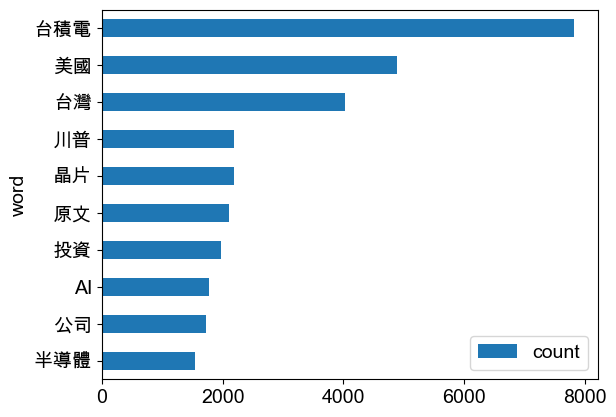

In [78]:
freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

<h4>文字雲</h4>

In [79]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

freq_dict

{'台積電': 7817,
 '美國': 4879,
 '台灣': 4017,
 '川普': 2193,
 '晶片': 2180,
 '原文': 2098,
 '投資': 1971,
 'AI': 1771,
 '公司': 1721,
 '半導體': 1535,
 '中國': 1484,
 '市場': 1448,
 '可能': 1306,
 '英特爾': 1203,
 '就是': 1190,
 '資增': 1164,
 '可以': 1164,
 '券增': 1157,
 '標題': 1146,
 '技術': 1129,
 '製程': 1113,
 '關稅': 1095,
 '產業': 1067,
 '表示': 1066,
 '台股': 1035,
 '元大': 1020,
 '交易': 973,
 '先進': 962,
 '現在': 922,
 '記者': 910,
 '心得': 905,
 '政府': 902,
 '沒有': 881,
 '股價': 868,
 '目前': 845,
 '今年': 829,
 '未來': 829,
 '奈米': 817,
 '科技': 816,
 '股票': 808,
 '全球': 802,
 '不是': 801,
 '內容': 799,
 '外資': 793,
 '億美': 792,
 '企業': 773,
 '連結': 769,
 '如果': 768,
 '輝達': 760,
 'KY': 748,
 '生產': 741,
 '評論': 740,
 '客戶': 713,
 '因為': 710,
 '我們': 705,
 '需求': 693,
 '指數': 691,
 '台積': 689,
 '指出': 685,
 '製造': 680,
 '報導': 673,
 '三星': 664,
 '來源': 656,
 '還是': 650,
 'ETF': 646,
 '排行': 631,
 '成長': 629,
 '已經': 621,
 '鴻海': 618,
 '影響': 614,
 '股息': 607,
 '開始': 604,
 '持續': 603,
 '證券': 602,
 '買超': 601,
 '所以': 596,
 '認為': 592,
 '問題': 590,
 '營收': 578,
 '一個': 574,
 '真的': 573

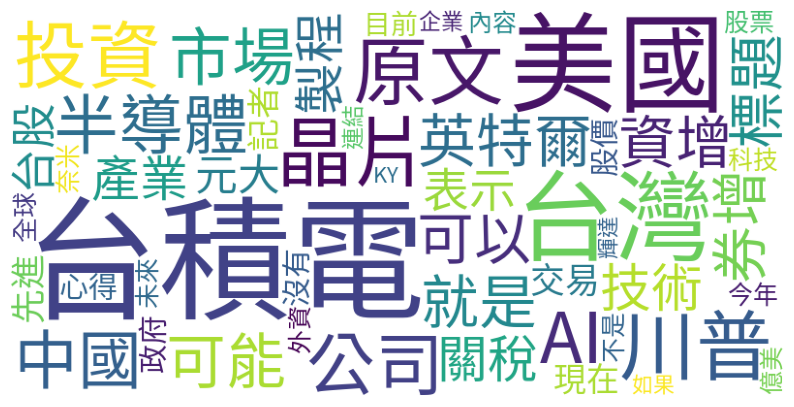

In [80]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, max_words = 50, font_path = FontPath)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<h3>2.7移除停用字</h3>

In [81]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('raw_data//dict/stopwords.txt', 'r', encoding='utf-8').readlines()]

移除df中的停用字

In [82]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",TW
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",台積電
2,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分類
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",正文
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",今年
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",第三季
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",靠近
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",尾端


<h3>計算去除停用字後的詞頻</h3>

<h3>再次繪製長條圖</h3>

/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/583685406.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


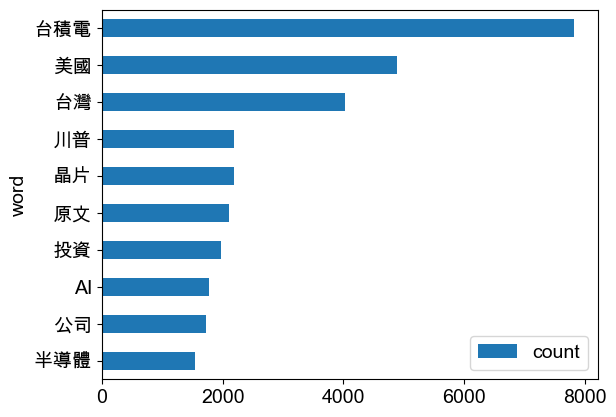

In [83]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

<h3>再次繪製文字雲</h3>

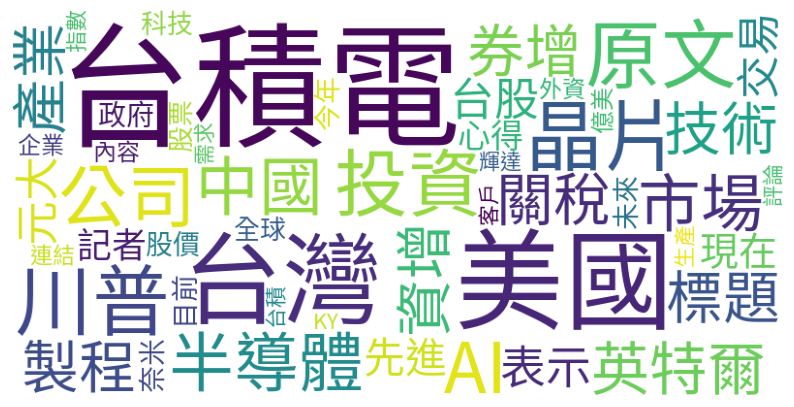

In [84]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

<h3>更新停用字字典</h3>

In [85]:
# 參數形式手動加入停用字
stopwords_manual = ["原文", "標題", "今年", "來源", "公司", "評論", "署名", "內容時間", "現在", "連結", "目前", "股票",
                    "股價", "台積電", "台積", "台股", "台灣", "台灣股市", "台灣股票", "台灣股價", "台灣股票市場",
                    "台灣股市", "內容", "評論", "文章", "內文", "記者", "指出", "心得", "來源", "市場", "表示", "去年",
                    "預期", "億元", "TW", "持續", "未來", "產業", "券增", "排行", "證券", "今天", "報導", "分類",
                    "網址", "時間", "客戶", "認為", "討論", "張數", "相關", "影響", "機制", "億美元", "美元", "企業",
                    "金額", "資料", "發布", "格式", "投資"]

stopwords.extend(stopwords_manual)

In [86]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",正文
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",第三季
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",靠近
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",尾端
5,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",打一些
5,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",第四季
5,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",明年
5,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",展望


<h3>2.9更新斷詞字典</h3>

利用<中文金融情感詞典>作為金融領域斷詞字典
來源:https://github.com/MengLingchao/Chinese_financial_sentiment_dictionary

In [87]:
#原詞典為簡體，因此利用openCC套件將excel轉成繁體
# 初始化簡轉繁的轉換器
converter = opencc.OpenCC('s2t')  # 簡體轉繁體
# 讀取 Excel 檔案（所有 Sheets）
xls = pd.ExcelFile("raw_data/chineseEmotion.xlsx", engine='openpyxl')
# 轉換所有 Sheets
converted_sheets = {}
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name, engine='openpyxl')  # 讀取該 Sheet
    df = df.applymap(lambda x: converter.convert(x) if isinstance(x, str) else x)  # 轉換簡體到繁體
    converted_sheets[sheet_name] = df  # 存入字典
# 存回新的 Excel 檔案（包含所有 Sheets）
with pd.ExcelWriter("sentTraditional.xlsx", engine='openpyxl') as writer:
    for sheet_name, df in converted_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(" 轉換完成，已存為chineseEmotionTraditional.xlsx，並保留所有 Sheets！")

 轉換完成，已存為chineseEmotionTraditional.xlsx，並保留所有 Sheets！


/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/1498013114.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: converter.convert(x) if isinstance(x, str) else x)  # 轉換簡體到繁體
/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/1498013114.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: converter.convert(x) if isinstance(x, str) else x)  # 轉換簡體到繁體
/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/1498013114.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: converter.convert(x) if isinstance(x, str) else x)  # 轉換簡體到繁體


In [88]:
pos_table = pd.read_excel('raw_data/sentTranditional.xlsx','positive')
neg_table = pd.read_excel('raw_data/sentTranditional.xlsx','negative')
# 去除所有欄位的換行符（適用於開頭與結尾）
pos_table = pos_table.applymap(lambda x: x.strip() if isinstance(x, str) else x)
neg_table = neg_table.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#合併正反面詞
# 重新命名欄位，使其統一為 'word'
pos_table.columns = ['word']
neg_table.columns = ['word']

# 合併兩個 DataFrame
user_dict = pd.concat([pos_table, neg_table], ignore_index=True)

#載入自定義dict
#將 user_dict 變數存為 user_dict.txt，每行一個詞
# 確保目標資料夾存在（如果不存在就創建）
output_dir = "raw_data/dict"
os.makedirs(output_dir, exist_ok=True)  # 自動建立資料夾（如果不存在）
# 設定存檔路徑
output_path = os.path.join(output_dir, "user_dict.txt")
user_dict.to_csv(output_path, index=False, header=False, sep="\n", encoding="utf-8")
print("已成功儲存")


已成功儲存


/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/1513540937.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pos_table = pos_table.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/1513540937.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neg_table = neg_table.applymap(lambda x: x.strip() if isinstance(x, str) else x)


<h3>重新斷詞</h3>

In [89]:
# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict("raw_data//dict/user_dict.txt")
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]
word_df_updated

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",TW
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",台積電
2,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分類
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析
...,...,...,...,...,...
144966,https://www.ptt.cc/bbs/Stock/M.1741712550.A.F9...,[標的]9958世紀鋼。空,2025-03-12,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,進場
144966,https://www.ptt.cc/bbs/Stock/M.1741712550.A.F9...,[標的]9958世紀鋼。空,2025-03-12,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,開盤
144967,https://www.ptt.cc/bbs/Stock/M.1741712550.A.F9...,[標的]9958世紀鋼。空,2025-03-12,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,停損
144968,https://www.ptt.cc/bbs/Stock/M.1741712550.A.F9...,[標的]9958世紀鋼。空,2025-03-12,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,停利


<h3>重新移除停用字</h3>

In [90]:
nostop_df_updated = word_df_updated[~word_df_updated['word'].isin(stopwords)]

nostop_df_updated

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",正文
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",第三季
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",靠近
...,...,...,...,...,...
144966,https://www.ptt.cc/bbs/Stock/M.1741712550.A.F9...,[標的]9958世紀鋼。空,2025-03-12,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,進場
144966,https://www.ptt.cc/bbs/Stock/M.1741712550.A.F9...,[標的]9958世紀鋼。空,2025-03-12,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,開盤
144967,https://www.ptt.cc/bbs/Stock/M.1741712550.A.F9...,[標的]9958世紀鋼。空,2025-03-12,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,停損
144968,https://www.ptt.cc/bbs/Stock/M.1741712550.A.F9...,[標的]9958世紀鋼。空,2025-03-12,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,停利


<h3>重新計算詞頻</h3>

In [91]:
freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_updated

/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/4165249668.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()


,word,count
0,美國,4879
1,川普,2193
2,晶片,2180
3,AI,1771
4,半導體,1535
...,...,...
36196,火燒,1
36197,Bonding,1
36198,VNAND,1
36199,韓系,1


<h3>重新繪製詞頻長條圖</h3>

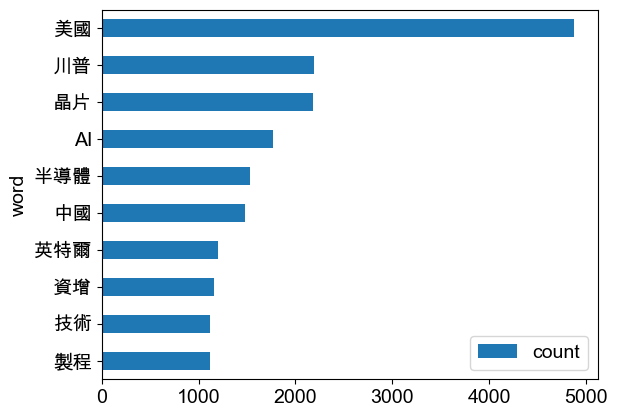

In [92]:
freq_df_updated.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

<h3>繪製文字雲</h3>

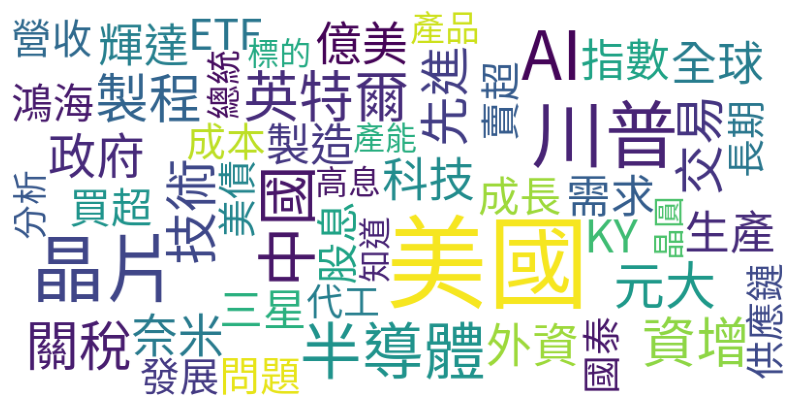

In [93]:
freq_dict_updated = freq_df_updated.set_index('word').to_dict()
freq_dict_updated = freq_dict_updated['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict_updated)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

<h3>2.10比較清理前後文字雲</h3>

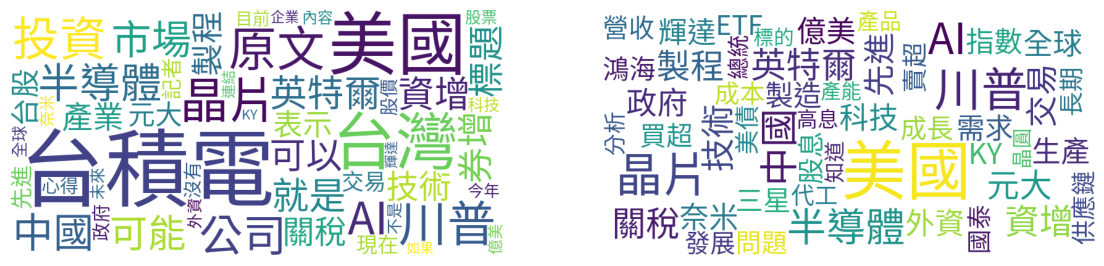

In [94]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wordcloud_after)
plt.axis('off')

plt.show()

<h2>3情緒分析</h2>

<h3>3.1準備LIWC情緒字典</h3>

In [95]:
# 讀取情緒字典
liwc_dict = pd.read_csv("raw_data//dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [96]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

<h3>3.2情緒字典與斷詞結果合併</h3>

In [97]:
ptt_liwc_df = pd.merge(nostop_df_updated[[ "artUrl","artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")


# 修正 artDate 格式
ptt_liwc_df["artDate"] = ptt_liwc_df["artDate"].astype(str)
ptt_liwc_df["artDate"] = ptt_liwc_df["artDate"].apply(lambda x: re.sub(r'["{}]', '', x))
ptt_liwc_df["artDate"] = pd.to_datetime(ptt_liwc_df["artDate"], errors="coerce")

# 排除轉換失敗的日期（可能是錯誤值）
ptt_liwc_df = ptt_liwc_df.dropna(subset=["artDate"])

<h3>3.3 正負向情緒詞彙頻率折線圖圖</h3>

In [98]:
#先計算詞頻
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
3,2024-09-01,negative,3
4,2024-09-01,positive,18
6,2024-09-02,negative,3
7,2024-09-02,positive,30
12,2024-09-03,negative,12
...,...,...,...
1075,2025-03-09,positive,96
1080,2025-03-10,negative,55
1081,2025-03-10,positive,89
1086,2025-03-11,negative,38


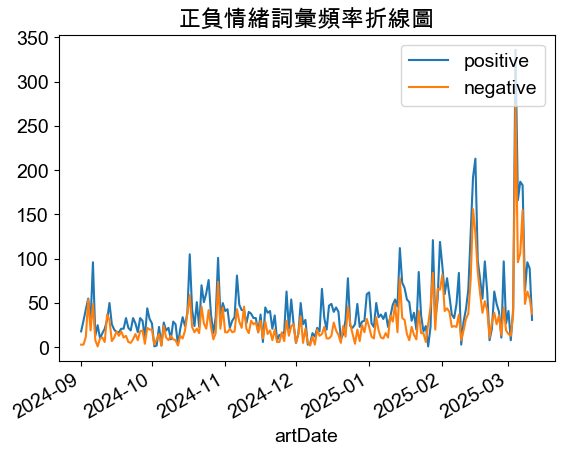

In [99]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖")  # 記得加上才能顯示中文
plt.show()

<h3>Moving Average</h3>

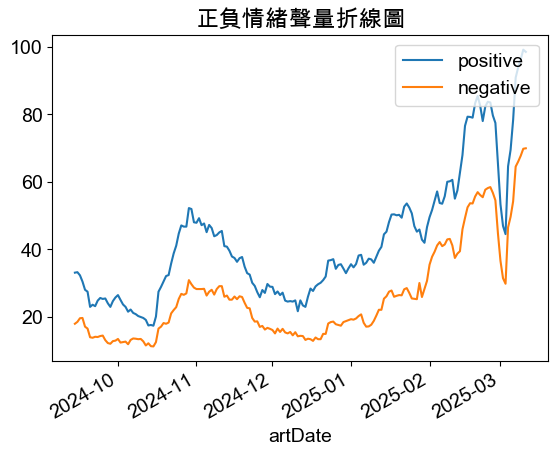

In [100]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖")  # 記得加上才能顯示中文
plt.show()

<h3>3.4正負相情緒詞彙比例折線圖</h3>

In [101]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
3,2024-09-01,negative,3,0.142857
4,2024-09-01,positive,18,0.857143
6,2024-09-02,negative,3,0.090909
7,2024-09-02,positive,30,0.909091
12,2024-09-03,negative,12,0.218182
...,...,...,...,...
1075,2025-03-09,positive,96,0.603774
1080,2025-03-10,negative,55,0.381944
1081,2025-03-10,positive,89,0.618056
1086,2025-03-11,negative,38,0.550725


In [102]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

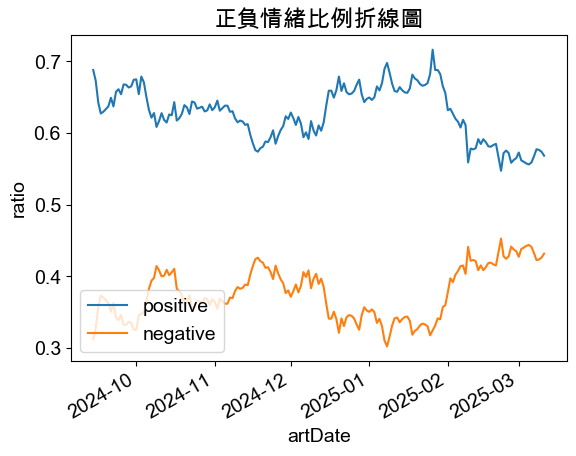

In [103]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

<h3>3.5正負相情緒分數折線圖</h3>

In [104]:
sentiment_count

,artDate,sentiments,size,ratio
3,2024-09-01,negative,3,0.142857
4,2024-09-01,positive,18,0.857143
6,2024-09-02,negative,3,0.090909
7,2024-09-02,positive,30,0.909091
12,2024-09-03,negative,12,0.218182
...,...,...,...,...
1075,2025-03-09,positive,96,0.603774
1080,2025-03-10,negative,55,0.381944
1081,2025-03-10,positive,89,0.618056
1086,2025-03-11,negative,38,0.550725


In [105]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2024-09-01,3.0,18.0
1,2024-09-02,3.0,30.0
2,2024-09-03,12.0,43.0
3,2024-09-04,54.0,55.0
4,2024-09-05,19.0,29.0


In [106]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2024-09-01,3.0,18.0,15.0
1,2024-09-02,3.0,30.0,27.0
2,2024-09-03,12.0,43.0,31.0
3,2024-09-04,54.0,55.0,1.0
4,2024-09-05,19.0,29.0,10.0


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

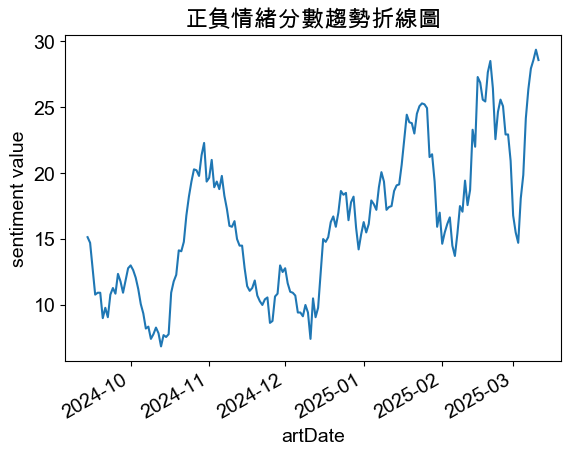

In [107]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

<h3>3.6文章為單位的情緒分析</h3>

In [108]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,affect,14
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,anger,1
2,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,anx,1
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,negative,3
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,positive,9
...,...,...,...
7152,https://www.ptt.cc/bbs/Stock/M.1741708181.A.24...,affect,4
7153,https://www.ptt.cc/bbs/Stock/M.1741708181.A.24...,anger,2
7154,https://www.ptt.cc/bbs/Stock/M.1741708181.A.24...,anx,1
7155,https://www.ptt.cc/bbs/Stock/M.1741708181.A.24...,negative,2


In [109]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,14.0,1.0,1.0,3.0,9.0,0.0
1,https://www.ptt.cc/bbs/Stock/M.1725198616.A.9A...,9.0,0.0,0.0,0.0,9.0,0.0
2,https://www.ptt.cc/bbs/Stock/M.1725240995.A.EA...,12.0,0.0,0.0,2.0,7.0,1.0
3,https://www.ptt.cc/bbs/Stock/M.1725269627.A.BC...,12.0,0.0,0.0,0.0,12.0,0.0
4,https://www.ptt.cc/bbs/Stock/M.1725271202.A.22...,11.0,0.0,0.0,0.0,10.0,0.0


In [110]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,14.0,1.0,1.0,3.0,9.0,0.0,6.0
1,https://www.ptt.cc/bbs/Stock/M.1725198616.A.9A...,9.0,0.0,0.0,0.0,9.0,0.0,9.0
2,https://www.ptt.cc/bbs/Stock/M.1725240995.A.EA...,12.0,0.0,0.0,2.0,7.0,1.0,5.0
3,https://www.ptt.cc/bbs/Stock/M.1725269627.A.BC...,12.0,0.0,0.0,0.0,12.0,0.0,12.0
4,https://www.ptt.cc/bbs/Stock/M.1725271202.A.22...,11.0,0.0,0.0,0.0,10.0,0.0,10.0


In [111]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,14.0,1.0,1.0,3.0,9.0,0.0,6.0,正向
1,https://www.ptt.cc/bbs/Stock/M.1725198616.A.9A...,9.0,0.0,0.0,0.0,9.0,0.0,9.0,正向
2,https://www.ptt.cc/bbs/Stock/M.1725240995.A.EA...,12.0,0.0,0.0,2.0,7.0,1.0,5.0,正向
3,https://www.ptt.cc/bbs/Stock/M.1725269627.A.BC...,12.0,0.0,0.0,0.0,12.0,0.0,12.0,正向
4,https://www.ptt.cc/bbs/Stock/M.1725271202.A.22...,11.0,0.0,0.0,0.0,10.0,0.0,10.0,正向
...,...,...,...,...,...,...,...,...,...
2037,https://www.ptt.cc/bbs/Stock/M.1741681874.A.F2...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
2038,https://www.ptt.cc/bbs/Stock/M.1741683976.A.A8...,4.0,0.0,3.0,3.0,0.0,1.0,-3.0,負向
2039,https://www.ptt.cc/bbs/Stock/M.1741696348.A.F5...,8.0,1.0,0.0,1.0,5.0,0.0,4.0,正向
2040,https://www.ptt.cc/bbs/Stock/M.1741707123.A.8B...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向


In [112]:

# 合併後轉換 artDate
clear_df_sentiment = pd.merge(raw_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
# 確保 artDate 欄位為字串，避免雜訊
clear_df_sentiment["artDate"] = clear_df_sentiment["artDate"].astype(str).str.strip()
# 嘗試轉換日期，錯誤的值變成 NaT
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"], errors="coerce")
# 檢查無效日期
#print("無效日期數量:", clear_df_sentiment["artDate"].isna().sum())
# 查看無效日期的前 20 筆
#invalid_dates = clear_df_sentiment[clear_df_sentiment["artDate"].isna()]
#print(invalid_dates[["artDate"]].head(20))
# 選擇是否要刪除無效日期
clear_df_sentiment = clear_df_sentiment.dropna(subset=["artDate"])
print("artDate 已成功轉換，合併後的 DataFrame：")
clear_df_sentiment["artDate"] = clear_df_sentiment["artDate"].dt.date

clear_df_sentiment



artDate 已成功轉換，合併後的 DataFrame：


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,Lefty,Stock,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""kkes0001"", ""...",180.177.26.33,2024/9/2 2:03,ptt,正向
1,2,https://www.ptt.cc/bbs/Stock/M.1725197370.A.1F...,[標的]大盤跟外資喊話多,2024-09-01,derrengay,Stock,帕拉迪島=台灣\n\n調查兵團=台積電\n\n艾倫=張忠謀\n\n我在這邊公開跟會看PTT的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""xxgogg"", ""cm...",112.78.86.207,2024/9/2 2:03,ptt,NaN
2,3,https://www.ptt.cc/bbs/Stock/M.1725198616.A.9A...,[新聞]黑悟空帶飛台灣PC、遊戲股？鈊象、大宇,2024-09-01,cjol,Stock,黑悟空帶飛台灣PC、遊戲股？鈊象、大宇資、宇峻齊紅！智崴漲近半根\n\n\nFTNN新聞網\...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""st9061204"", ...",122.117.2.178,2024/9/2 2:03,ptt,正向
3,4,https://www.ptt.cc/bbs/Stock/M.1725240995.A.EA...,[新聞]悟空也難救？面板廠9月起擴大減產,2024-09-02,ann16,Stock,原文標題：悟空也難救？面板廠9月起擴大減產\n原文連結：\nhttps://reurl.cc...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""GoGoRoll"", ""...",203.145.94.152,2024/9/3 2:10,ptt,正向
4,5,https://www.ptt.cc/bbs/Stock/M.1725256802.A.98...,[閒聊]2024/09/02盤後閒聊,2024-09-02,vendan5566,Stock,"台股\n成交量2861.94億\n台指09\n成交量 72,167口\n櫃買指\n成交量11...","[{""cmtStatus"": ""噓"", ""cmtPoster"": ""addy7533967""...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2542,2542,https://www.ptt.cc/bbs/Stock/M.1741696348.A.F5...,[新聞]0050奪回定期定額人氣王K值小於20正是,2025-03-11,humbler,Stock,原文標題：\n0050奪回定期定額人氣王 K值小於20正是獲利進場點？\n\n原文連結：\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""locallo"", ""c...",1.169.203.178,2025/3/12 1:35,ptt,正向
2543,2543,https://www.ptt.cc/bbs/Stock/M.1741699409.A.CC...,[情報]114年03月11日信用交易統計,2025-03-11,steward135,Stock,1. 標題：114年03月11日信用交易統計\n2. 來源：臺灣證券交易所、證券櫃檯買賣中心...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zo4j4"", ""cmt...",36.224.76.182,2025/3/12 1:35,ptt,NaN
2544,2544,https://www.ptt.cc/bbs/Stock/M.1741707123.A.8B...,[情報]0311上市櫃外資投信買超金額排行,2025-03-11,steveisaman,Stock,外資\n\n排行 股票名稱 收盤價 漲跌 買超(百萬)\n\n1 ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KIMBEOM"", ""c...",180.177.56.41,2025/3/12 1:35,ptt,正向
2545,2545,https://www.ptt.cc/bbs/Stock/M.1741708181.A.24...,[新聞]川普再放話：加拿大成為美國第51州,2025-03-11,humbler,Stock,原文標題：\n川普再放話：加拿大成為美國第51州\n\n原文連結：\nhttps://www...,[],1.169.203.178,2025/3/12 1:35,ptt,負向


In [113]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2024-09-01,正向,2
1,2024-09-02,正向,4
2,2024-09-02,負向,1
3,2024-09-03,正向,6
4,2024-09-04,正向,10
...,...,...,...
359,2025-03-09,負向,9
360,2025-03-10,正向,13
361,2025-03-10,負向,6
362,2025-03-11,正向,5


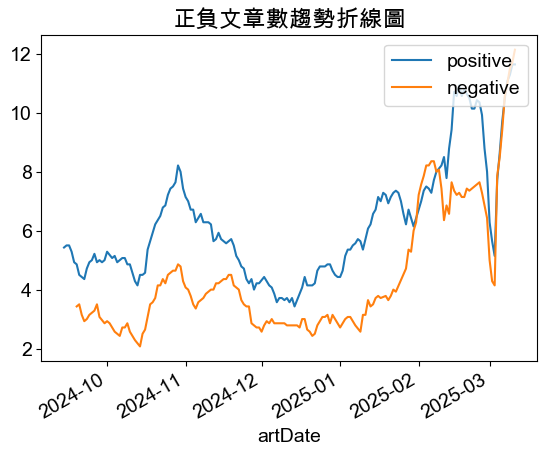

In [114]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")  # 記得加上才能顯示中文
plt.show()

在2024年10月~2025年2月間，大多數文章被歸類在正面，但在3月台積電確定到美國擴大投資，負面情緒的文章數量明顯上升，正反兩面數量相當。

<h3>情緒代表字</h3>

In [115]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
410,問題,affect,571
411,問題,negative,571
1881,重要,positive,343
1880,重要,affect,343
1948,風險,affect,324
...,...,...,...
1643,舒適,positive,1
1642,舒適,affect,1
747,悔恨,affect,1
1238,漠不關心,affect,1


In [116]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
1881,重要,positive,343
1060,智慧,positive,294
626,希望,positive,269
187,優勢,positive,225
902,投入,positive,210
930,挑戰,positive,208
999,支持,positive,192
565,安全,positive,180
1438,相信,positive,179
1751,謝謝,positive,153


In [117]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
411,問題,negative,571
1950,風險,negative,324
991,擔心,negative,170
1906,降低,negative,170
480,壓力,negative,155
1694,衝擊,negative,139
1688,虧損,negative,111
859,戰爭,negative,100
558,威脅,negative,83
994,擔憂,negative,76


/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/2349181045.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"])
/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/2349181045.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

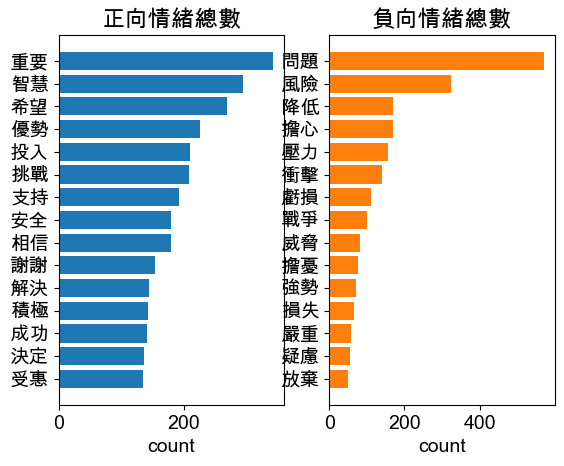

In [118]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

<h3>檢查情緒詞是否符合文本</h3>

In [119]:
filtered_df = sent_df[sent_df['sentence'].str.contains('挑戰', na=False)]
filtered_df.head()

,artUrl,artTitle,artDate,artContent,sentence
917,https://www.ptt.cc/bbs/Stock/M.1725316477.A.C1...,[新聞]英特爾求生賣業務、停建德廠,2024-09-03,原文標題：\n\n英特爾求生 賣業務、停建德廠\n\n\n原文連結：\nhttps://re...,更有機會挑戰輝達與超微
1252,https://www.ptt.cc/bbs/Stock/M.1725375915.A.EB...,[新聞]美股早盤盡墨！晶片股湧賣壓輝達重挫6%,2024-09-03,原文標題：\n美股早盤盡墨！晶片股湧賣壓 輝達重挫6%、台積ADR跌逾4%\n\n原文連結：...,這是歷史上向來會遭遇挑戰的月份
9836,https://www.ptt.cc/bbs/Stock/M.1726387023.A.6D...,[新聞]長榮、兆豐金等16檔強勢「登月」中秋盤,2024-09-15,原文標題：長榮、兆豐金等16檔強勢「登月」 中秋盤勢怎麼變？\n\n原文連結：\nhttps...,在中秋前台股可望先挑戰月線
9841,https://www.ptt.cc/bbs/Stock/M.1726387023.A.6D...,[新聞]長榮、兆豐金等16檔強勢「登月」中秋盤,2024-09-15,原文標題：長榮、兆豐金等16檔強勢「登月」 中秋盤勢怎麼變？\n\n原文連結：\nhttps...,挑戰季線
9873,https://www.ptt.cc/bbs/Stock/M.1726387023.A.6D...,[新聞]長榮、兆豐金等16檔強勢「登月」中秋盤,2024-09-15,原文標題：長榮、兆豐金等16檔強勢「登月」 中秋盤勢怎麼變？\n\n原文連結：\nhttps...,台股日有機會先行挑戰觸碰月線位置


In [120]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

更有機會挑戰輝達與超微
這是歷史上向來會遭遇挑戰的月份
在中秋前台股可望先挑戰月線
挑戰季線
台股日有機會先行挑戰觸碰月線位置
則台股月有望收復月線挑戰觸碰季線
歷經年的挑戰
iPhone  Pro將用台積電奈米　生產有挑戰得依靠打群架
但是也遇到一些挑戰
風險與挑戰
台灣的能源困境是國家安全氣候和政治挑戰的結合
台灣目前的能源組合凸顯了挑戰的規模根據經濟部的資料
台灣的安全問題還涉及到更複雜的挑戰
客戶流失與戰略不確定的挑戰
 連台積電這麼強的企業在未來的未來都有可能遭遇更強的黑科技公司來挑戰
中國面臨許多習近平無法或不願面對的挑戰
今年挑戰大賺三個股本
台積電ADR率先創天價　台積電夜盤挑戰歷史高點
美元台積電夜盤則挑戰歷史高點元
團隊接下來的目標是持續挑戰並提升單一
但也面臨兩大挑戰
看好本季美元營收季增率高標挑戰
市場普遍預期後市台股有機會再度挑戰歷史新高
估單季營收將挑戰新高
指數有望再次挑戰
但本月初時便傳出興建新廠遇到挑戰
 出天量突破後挑戰前波高點 目前震盪
原文標題英特爾尋求三星組代工同盟 挑戰台積電
可以關注台灣面臨能源轉型的重大挑戰
並克服複雜的生命科學挑戰
輕微的失誤都可能會在晶片中造成連續性挑戰
為了緩解挑戰並釋放矽積體光路的超頻寬功能
使得模擬所有可能的參數組合的程序極具挑戰性
電子電路結合相關的多物理挑戰
是克服這些挑戰的關鍵策略
戶克服複雜的設計挑戰
這是當今最重要的晶片設計挑戰之一
有些產業還是會面臨供應鏈重組的挑戰
挑戰海內外總店數突破
未來的挑戰將更加嚴峻
相信一定能克服挑戰
面臨許多挑戰
更廣泛的貿易戰也可能對該行業構成挑戰
對如果是川普當選美國總統的新挑戰
兌現對投資人承諾方面所面臨的挑戰
在面對碳中和挑戰下
今年EPS挑戰元
台廠需要面對的挑戰更大
台廠供應鏈要注意租稅國際經貿情勢與政府補貼策略等大挑戰
台廠需要面對的挑戰更大
台廠供應鏈要注意租稅國際經貿情勢與政府補貼策略等大挑戰
以及台積電創立以來的挑戰與
的產業出口將面臨挑戰
 市場前景與挑戰
大同仍面臨來自國內外競爭對手的挑戰
該法案將幫助韓國企業應對挑戰
而且這東西一直在挑戰證券的耐心
台積電亞利桑那州廠面臨管理方面的挑戰
背後挑戰超乎預期
更大的科技和安全挑戰
反而對川普政府的國家安全和經濟政策構成挑戰
台積電的挑戰是要持續求發展
的挑戰
因此對台灣廠商來說恐是

<h3>重新計算情緒</h3>

In [121]:
# 設定要移除的字詞列表
words_to_remove = ['問題', '控制', '擔心', '錯過', '隨便', '強烈', '負擔', '口吃', '挑剔', '壓力', '邪惡', '禁止',
                   '挑戰', '謝謝', '智能', '智慧']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict_revise,
                              how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的,NaN
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",TW,NaN
2,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",台積電,NaN
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分類,NaN
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析,NaN


/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/1871799801.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"])
/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6508/1871799801.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

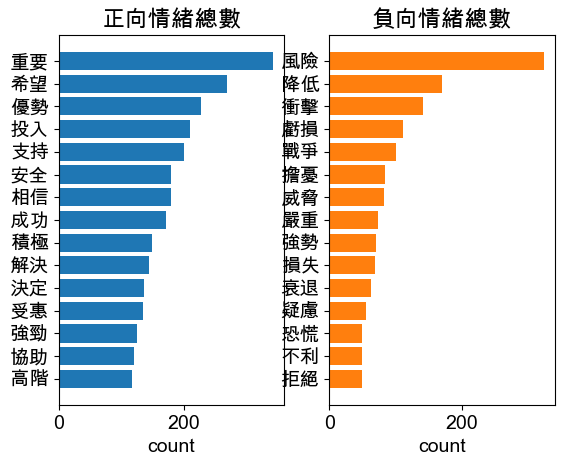

In [122]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

<h3>重新繪製情緒分數趨勢圖</h3>

In [123]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()
# 修正 artDate 格式
sentiment_count_revise["artDate"] = sentiment_count_revise["artDate"].astype(str)
sentiment_count_revise["artDate"] = sentiment_count_revise["artDate"].apply(lambda x: re.sub(r'["{}]', '', x))
sentiment_count_revise["artDate"] = pd.to_datetime(sentiment_count_revise["artDate"], errors="coerce")

# 排除轉換失敗的日期（可能是錯誤值）
sentiment_count_revise = sentiment_count_revise.dropna(subset=["artDate"])
sentiment_count_revise["artDate"] = sentiment_count_revise["artDate"].dt.date
sentiment_count_revise

,artDate,sentiments,0
0,2024-09-01,affect,23
1,2024-09-01,anger,1
2,2024-09-01,negative,3
3,2024-09-01,positive,18
4,2024-09-02,affect,36
...,...,...,...
1078,2025-03-11,anger,13
1079,2025-03-11,anx,12
1080,2025-03-11,negative,40
1081,2025-03-11,positive,30


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

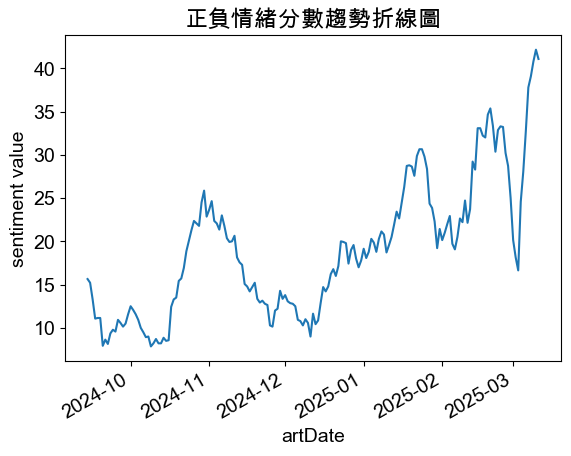

In [124]:
mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

<h3>文字雲</h3>

2024-10-01~2025-3-12文字雲
將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [125]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
# 修正 artDate 格式
ptt_liwc_df_revise["artDate"] = ptt_liwc_df_revise["artDate"].astype(str)
ptt_liwc_df_revise["artDate"] = ptt_liwc_df_revise["artDate"].apply(lambda x: re.sub(r'["{}]', '', x))
ptt_liwc_df_revise["artDate"] = pd.to_datetime(ptt_liwc_df_revise["artDate"], errors="coerce")

# 排除轉換失敗的日期（可能是錯誤值）
ptt_liwc_df_revise = ptt_liwc_df_revise.dropna(subset=["artDate"])
ptt_liwc_df_revise["artDate"] = ptt_liwc_df_revise["artDate"].dt.date
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的,NaN,正向
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",TW,NaN,正向
2,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",台積電,NaN,正向
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分類,NaN,正向
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,2024-09-01,[標的]台積電2025展望多,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析,NaN,正向


In [126]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
# 修正 artDate 格式
sent_df["artDate"] = sent_df["artDate"].astype(str)
sent_df["artDate"] = sent_df["artDate"].apply(lambda x: re.sub(r'["{}]', '', x))
sent_df["artDate"] = pd.to_datetime(sent_df["artDate"], errors="coerce")

# 排除轉換失敗的日期（可能是錯誤值）
sent_df = sent_df.dropna(subset=["artDate"])
sent_df["artDate"] = sent_df["artDate"].dt.date
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
0,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",標的,正向
1,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",TW 台積電,正向
2,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分類多,正向
3,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",分析正文,正向
4,https://www.ptt.cc/bbs/Stock/M.1725159108.A.FE...,[標的]台積電2025展望多,2024-09-01,"標的：\nTW 台積電\n分類：多\n分析/正文：\n\n今年第三季靠近尾端了, 打一些第四...",今年第三季靠近尾端了,正向


In [127]:
date = "2024-10-01"
end_date = "2025-03-12"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
45398,https://www.ptt.cc/bbs/Stock/M.1727748581.A.3C...,2024-10-01,"Re:[標的]2330.TW台積電,人棄我取,少少益善多~",笑死\n\nNvidia TSM\n\n到底是多菜？ 在那恐慌亂賣？\n\n這種龍頭跌是給...,笑死,affect,負向
45399,https://www.ptt.cc/bbs/Stock/M.1727748581.A.3C...,2024-10-01,"Re:[標的]2330.TW台積電,人棄我取,少少益善多~",笑死\n\nNvidia TSM\n\n到底是多菜？ 在那恐慌亂賣？\n\n這種龍頭跌是給...,笑死,positive,負向
45400,https://www.ptt.cc/bbs/Stock/M.1727748581.A.3C...,2024-10-01,"Re:[標的]2330.TW台積電,人棄我取,少少益善多~",笑死\n\nNvidia TSM\n\n到底是多菜？ 在那恐慌亂賣？\n\n這種龍頭跌是給...,Nvidia,NaN,負向
45401,https://www.ptt.cc/bbs/Stock/M.1727748581.A.3C...,2024-10-01,"Re:[標的]2330.TW台積電,人棄我取,少少益善多~",笑死\n\nNvidia TSM\n\n到底是多菜？ 在那恐慌亂賣？\n\n這種龍頭跌是給...,TSM,NaN,負向
45402,https://www.ptt.cc/bbs/Stock/M.1727748581.A.3C...,2024-10-01,"Re:[標的]2330.TW台積電,人棄我取,少少益善多~",笑死\n\nNvidia TSM\n\n到底是多菜？ 在那恐慌亂賣？\n\n這種龍頭跌是給...,多菜,NaN,負向
...,...,...,...,...,...,...,...
391478,https://www.ptt.cc/bbs/Stock/M.1741708181.A.24...,2025-03-11,[新聞]川普再放話：加拿大成為美國第51州,原文標題：\n川普再放話：加拿大成為美國第51州\n\n原文連結：\nhttps://www...,戰爭,anger,負向
391479,https://www.ptt.cc/bbs/Stock/M.1741708181.A.24...,2025-03-11,[新聞]川普再放話：加拿大成為美國第51州,原文標題：\n川普再放話：加拿大成為美國第51州\n\n原文連結：\nhttps://www...,美股,NaN,負向
391480,https://www.ptt.cc/bbs/Stock/M.1741708181.A.24...,2025-03-11,[新聞]川普再放話：加拿大成為美國第51州,原文標題：\n川普再放話：加拿大成為美國第51州\n\n原文連結：\nhttps://www...,看好,NaN,負向
391481,https://www.ptt.cc/bbs/Stock/M.1741708181.A.24...,2025-03-11,[新聞]川普再放話：加拿大成為美國第51州,原文標題：\n川普再放話：加拿大成為美國第51州\n\n原文連結：\nhttps://www...,加拿大,NaN,負向


In [128]:
date = "2024-10-01"
end_date = "2025-03-12"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
5003,台積電,2377
13057,美國,1962
4993,台灣,1274
6975,川普,867
9522,晶片,740
...,...,...
7357,延到,1
7360,延期,1
7361,延燒,1
7363,延至,1


(-0.5, 399.5, 199.5, -0.5)

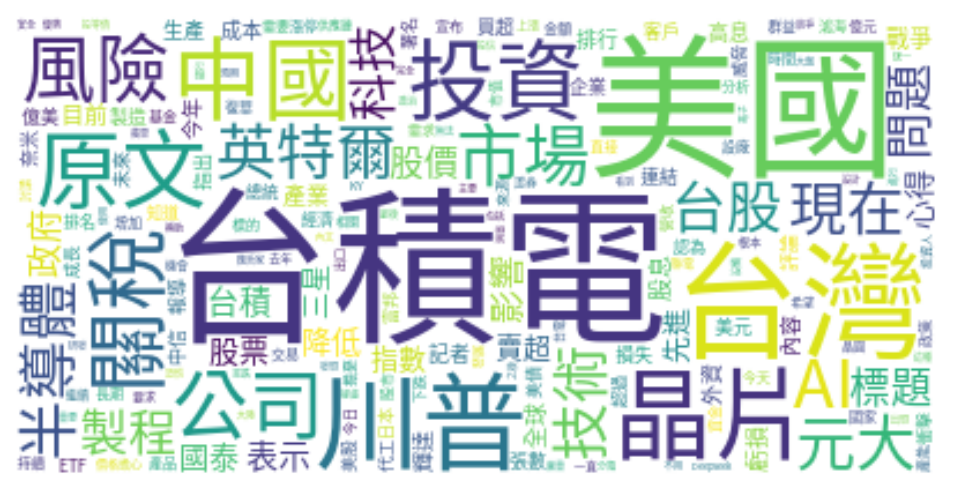

In [129]:
# wordcloud 的 input 是 dictionary
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=FontPath)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了區域名稱與美國總統如「川普」、「關稅」、「風險」、「投資」、「技術」等關鍵字，可能說明此類關鍵詞導致負面情緒文章上升。

(-0.5, 399.5, 199.5, -0.5)

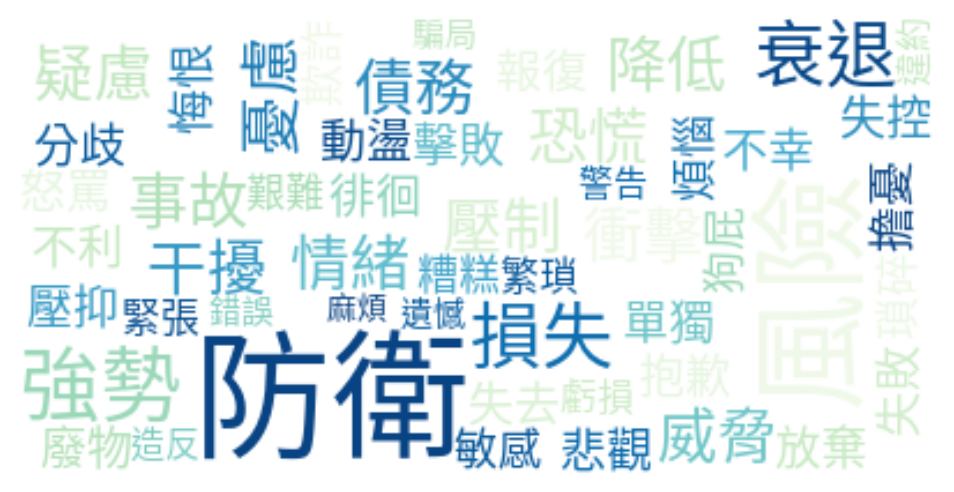

In [130]:
date = "2024-10-01"
end_date = "2025-03-12"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('美債')) & ( # 內文包含美債
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(max_words=200, background_color="white", font_path=FontPath, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

利用「風險」回查原文內容

In [131]:
print(sent_df.columns)


Index(['artUrl', 'artTitle', 'artDate', 'artContent', 'sentence',
       'sentiment_class'],
      dtype='object')


In [132]:
date = "2024-10-01"
end_date = "2025-03-12"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('川普')) & (
    sent_df['sentence'].str.contains('風險')) # 包含「風險」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
24725,https://www.ptt.cc/bbs/Stock/M.1729331653.A.74...,[標的]2330台積電利空探討,2024-10-19,標的：台積電 2330\n\n分類：討論\n\n分析/正文：\n\n在一片樂觀之際，提出這樣...,台積電獨霸一方,負向
24726,https://www.ptt.cc/bbs/Stock/M.1729331653.A.74...,[標的]2330台積電利空探討,2024-10-19,標的：台積電 2330\n\n分類：討論\n\n分析/正文：\n\n在一片樂觀之際，提出這樣...,自然是飛龍在天格局,負向
24727,https://www.ptt.cc/bbs/Stock/M.1729331653.A.74...,[標的]2330台積電利空探討,2024-10-19,標的：台積電 2330\n\n分類：討論\n\n分析/正文：\n\n在一片樂觀之際，提出這樣...,但飛龍在天後,負向
24728,https://www.ptt.cc/bbs/Stock/M.1729331653.A.74...,[標的]2330台積電利空探討,2024-10-19,標的：台積電 2330\n\n分類：討論\n\n分析/正文：\n\n在一片樂觀之際，提出這樣...,面對的是亢龍有悔,負向
24729,https://www.ptt.cc/bbs/Stock/M.1729331653.A.74...,[標的]2330台積電利空探討,2024-10-19,標的：台積電 2330\n\n分類：討論\n\n分析/正文：\n\n在一片樂觀之際，提出這樣...,因著地緣政治,負向
...,...,...,...,...,...,...
120577,https://www.ptt.cc/bbs/Stock/M.1741594641.A.52...,[新聞]台積電加碼對美投資，晶片戰爭作者,2025-03-10,原文標題：台積電加碼對美投資，晶片戰爭作者：仍根留台灣\n\n原文連結：\nhttps://...,台海安全,負向
120578,https://www.ptt.cc/bbs/Stock/M.1741594641.A.52...,[新聞]台積電加碼對美投資，晶片戰爭作者,2025-03-10,原文標題：台積電加碼對美投資，晶片戰爭作者：仍根留台灣\n\n原文連結：\nhttps://...,毛利率靠漲價就可以解決 製程領先就是一口價,負向
120579,https://www.ptt.cc/bbs/Stock/M.1741594641.A.52...,[新聞]台積電加碼對美投資，晶片戰爭作者,2025-03-10,原文標題：台積電加碼對美投資，晶片戰爭作者：仍根留台灣\n\n原文連結：\nhttps://...,他也提到無論如何台灣仍然會保留全球晶片主要的產能,負向
120580,https://www.ptt.cc/bbs/Stock/M.1741594641.A.52...,[新聞]台積電加碼對美投資，晶片戰爭作者,2025-03-10,原文標題：台積電加碼對美投資，晶片戰爭作者：仍根留台灣\n\n原文連結：\nhttps://...,你可以對鄉民質疑 但你要質疑晶片戰爭作者嗎,負向


文章大致關於台積電在美投資對其潛在利空與對台灣產業、房地產的影響